In [117]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gpt-vectorized-pickle/df_vectorized.pkl


In [164]:
# Imports
import os
import pandas as pd
import numpy as np
from collections import Counter
from datetime import date
import ast
import re
import math

# Scikit Learn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [119]:
# Use the exported data set from above
df2 = pd.read_pickle('/kaggle/input/gpt-vectorized-pickle/df_vectorized.pkl')

Text(0.5, 1.0, 'Distribution of Missing Values across the Data Set')

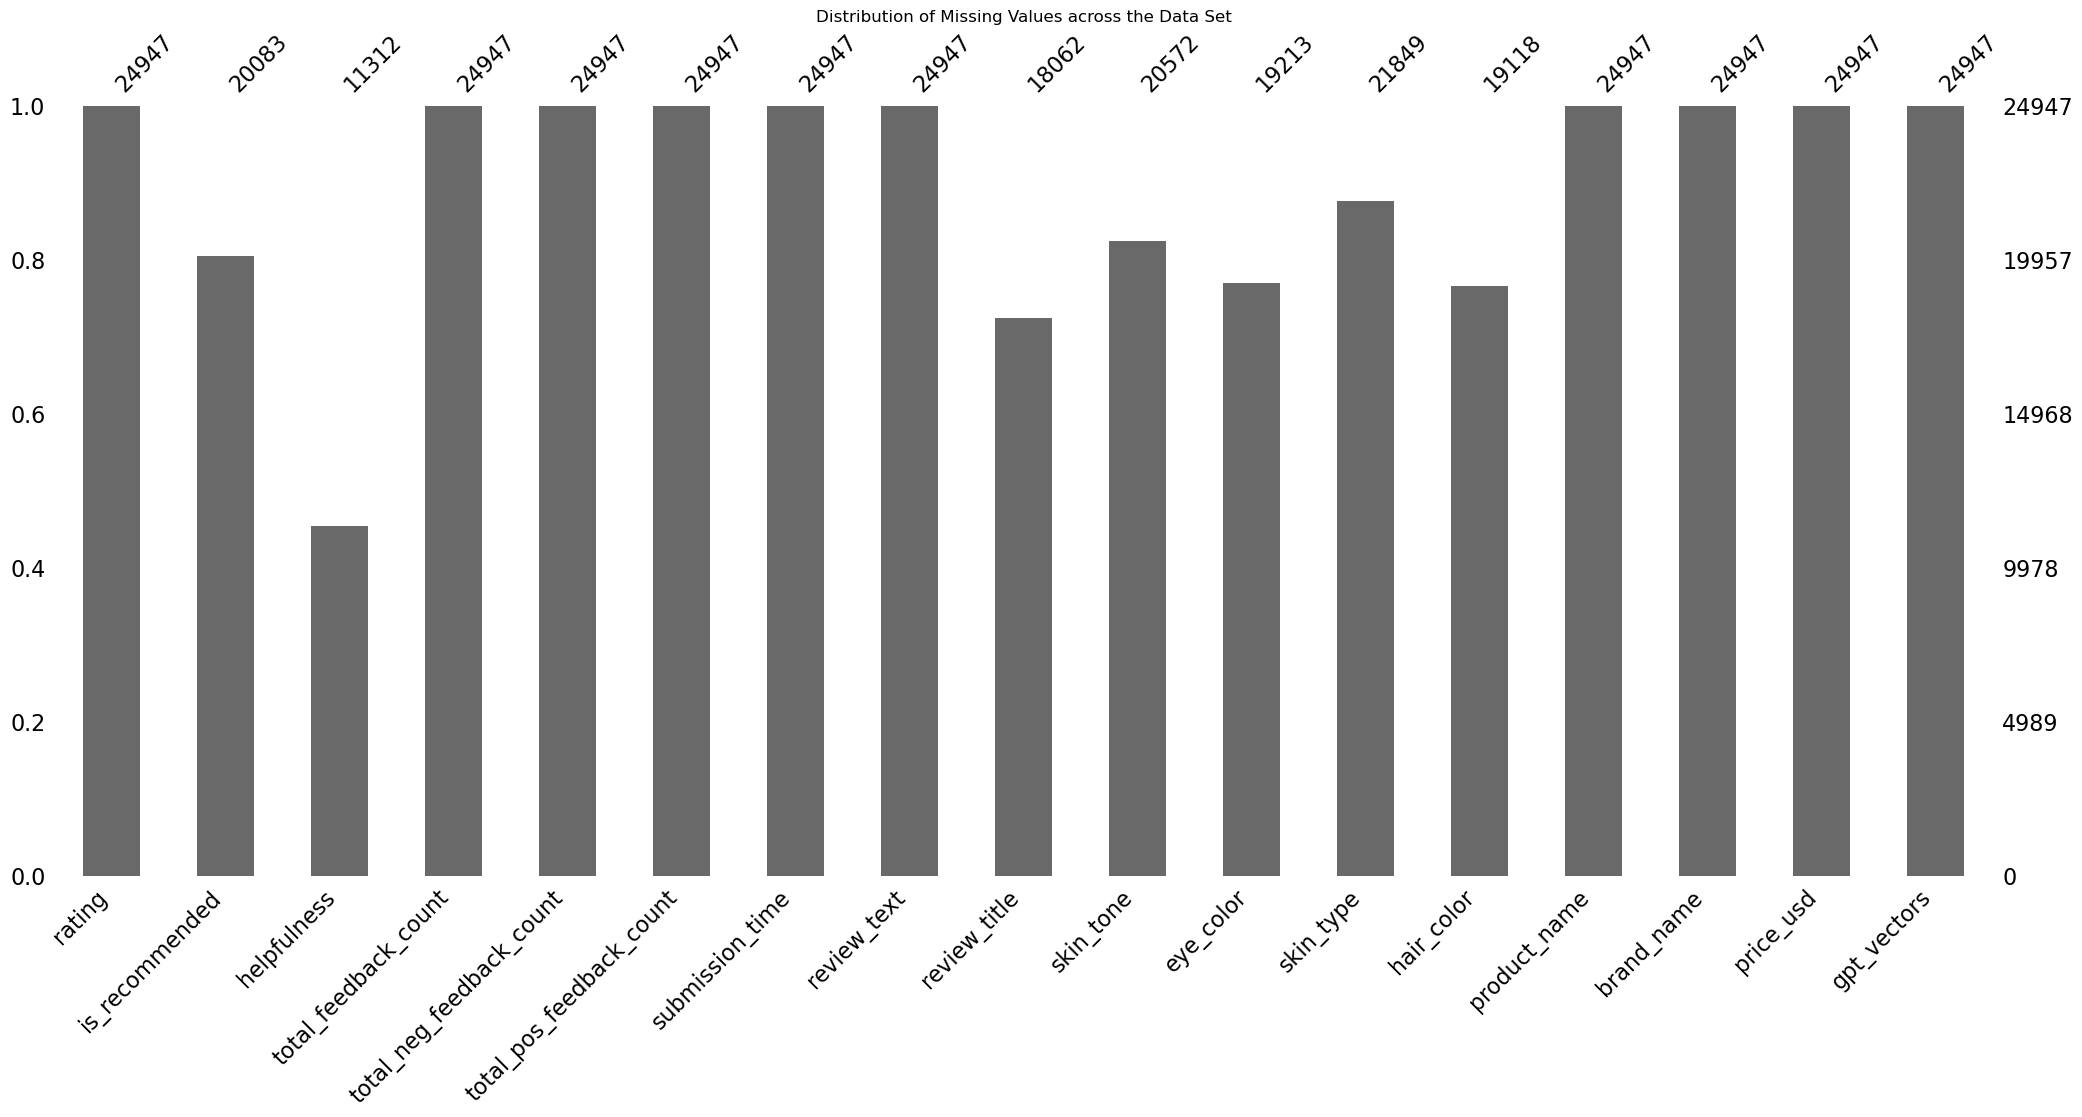

In [120]:
# Visualize the missing values
msno.bar(df2)

# Title
plt.title('Distribution of Missing Values across the Data Set')

Text(0.5, 1.0, 'Nullity Correlations')

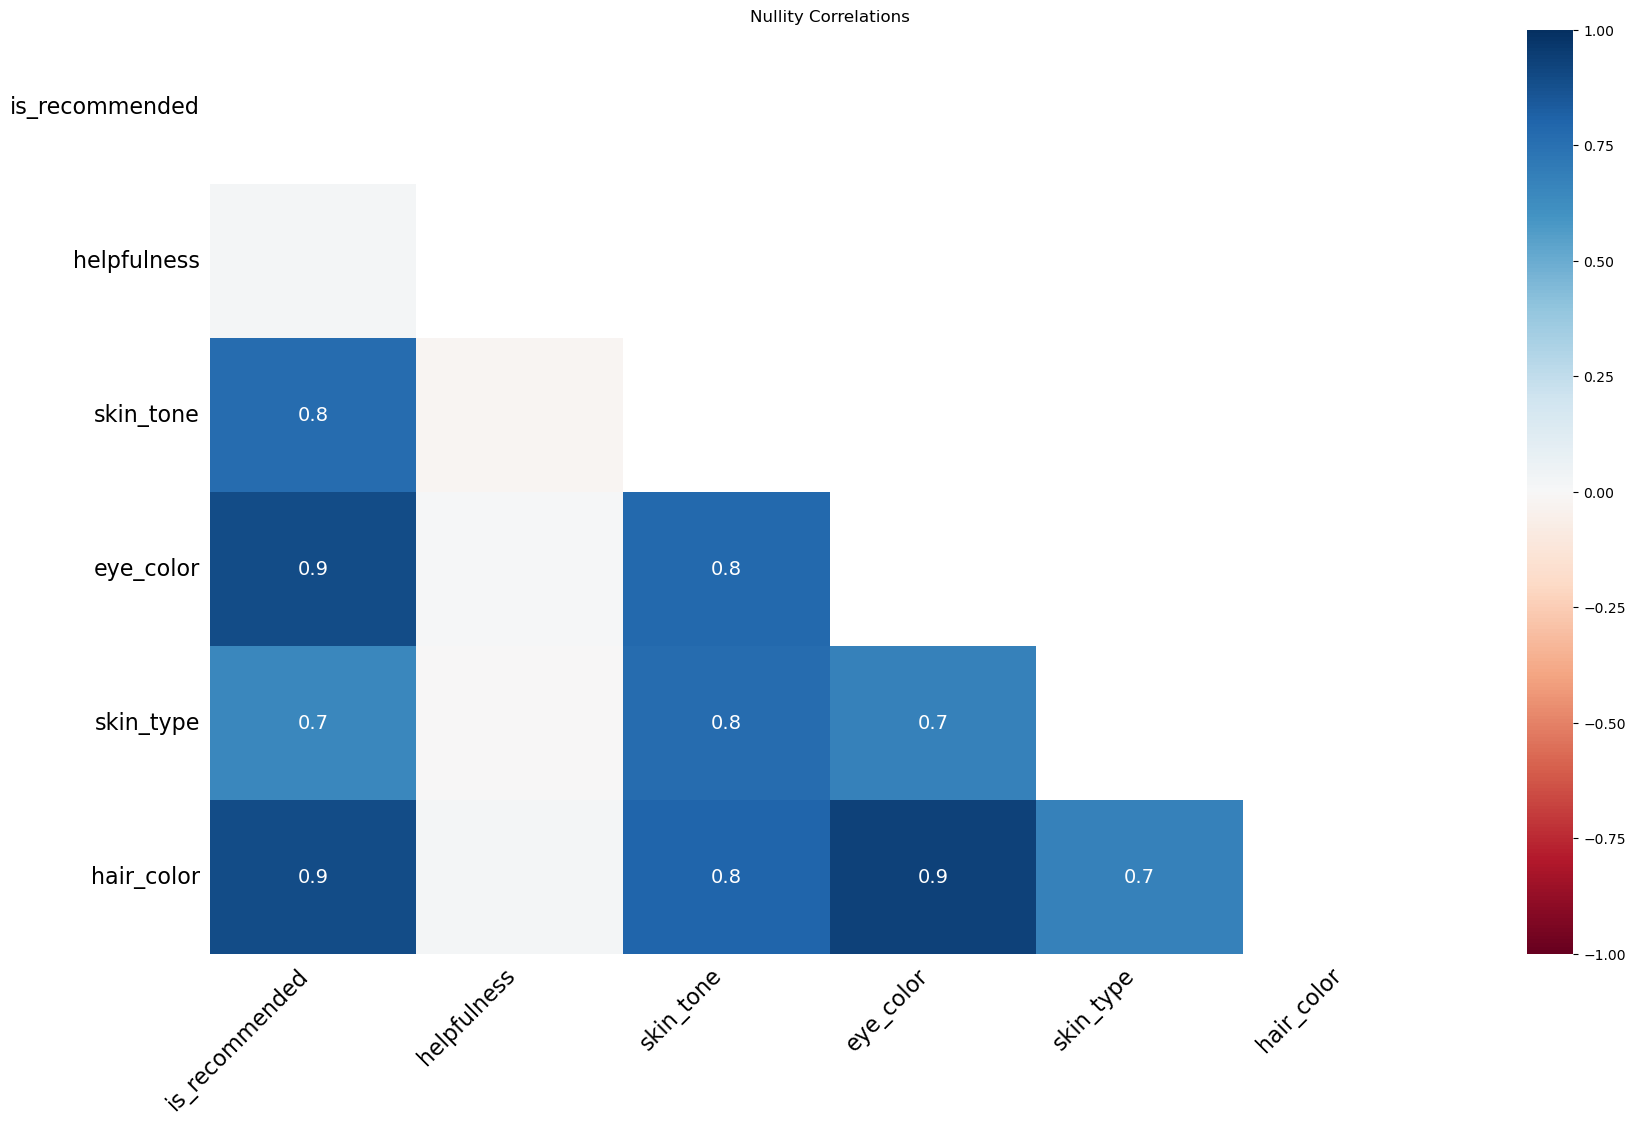

In [121]:
# Correlations among columns with missing values
heatmap_cols = [c for c in df2.columns if c != 'review_text' and c != 'review_title']

# Visualize
msno.heatmap(df2[heatmap_cols])

# Title
plt.title('Nullity Correlations')

### Remove Outliers based on Price USD

In [122]:
# Price USD - find outliers and remove them from the analysis
df2.price_usd.describe()

count    24947.000000
mean        45.423228
std         35.863111
min          3.000000
25%         22.000000
50%         38.000000
75%         58.000000
max        380.000000
Name: price_usd, dtype: float64

Text(0.5, 1.0, 'Price (USD) Boxplot')

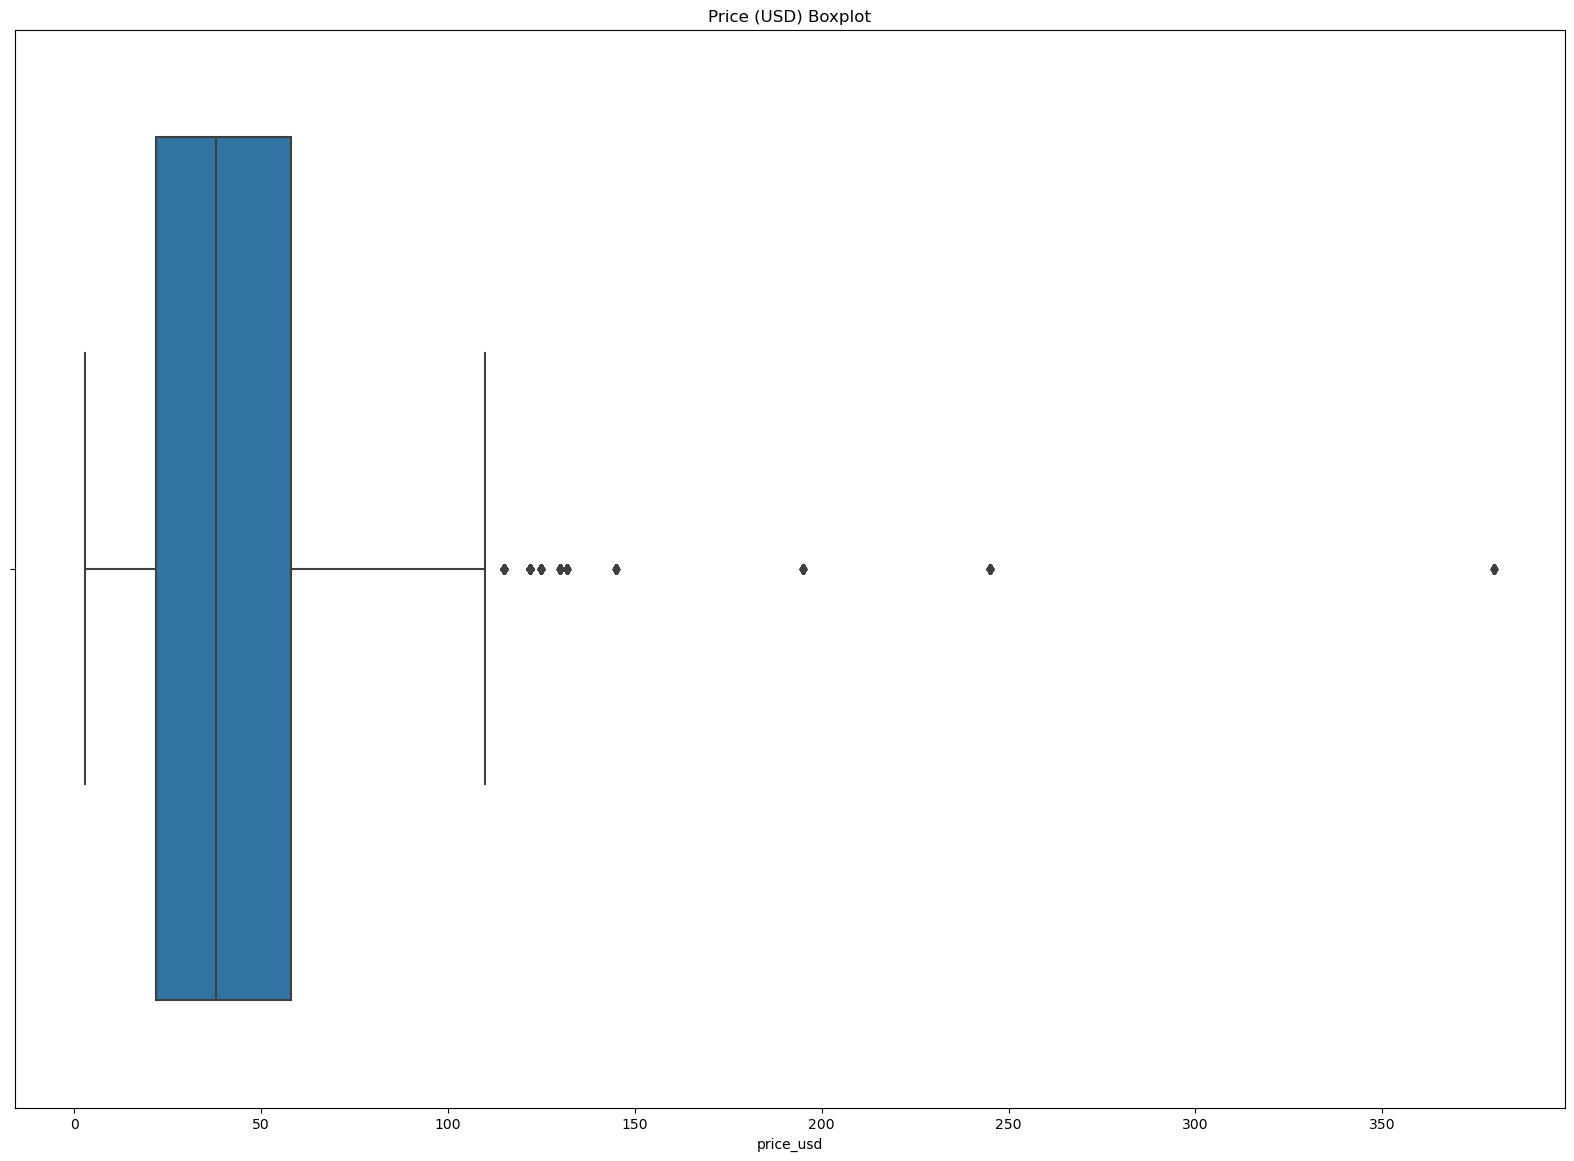

In [123]:
# Boxplot
# Size
plt.figure(figsize=(20,14))

# Boxplot
price_boxes = sns.boxplot(data=df2, x='price_usd')

# Titling
plt.title('Price (USD) Boxplot')

In [124]:
# Reset index in df2
df2.reset_index(drop=True, inplace=True)

In [125]:
# Identify the outlier values using Tukey's fence method
q1 = df2.price_usd.quantile(.25) # First quantile
q3 = df2.price_usd.quantile(.75) # Third quantile
iqr = q3-q1 # Interquartile range

# Inner fence lower and upper end
inner_fence_le = q1 - (1.5*iqr)
inner_fence_ue = q3 + (1.5*iqr)
    
# Outer fence lower and upper end
outer_fence_le = q1 - (3*iqr)
outer_fence_ue = q3 + (3*iqr)

# Outlier values
outliers = []

# Only find those that lay outside the outer fence values
for idx, i in enumerate(df2.price_usd):
    if i <= outer_fence_le or i >= outer_fence_ue:
        outliers.append(idx)

In [126]:
# Number of outliers
print(f'There are {len(outliers)} outliers in the price variable')

There are 278 outliers in the price variable


In [127]:
# Remove outliers
df2 = df2.drop(index=outliers, axis=1)

# Check
df2.shape

(24669, 17)

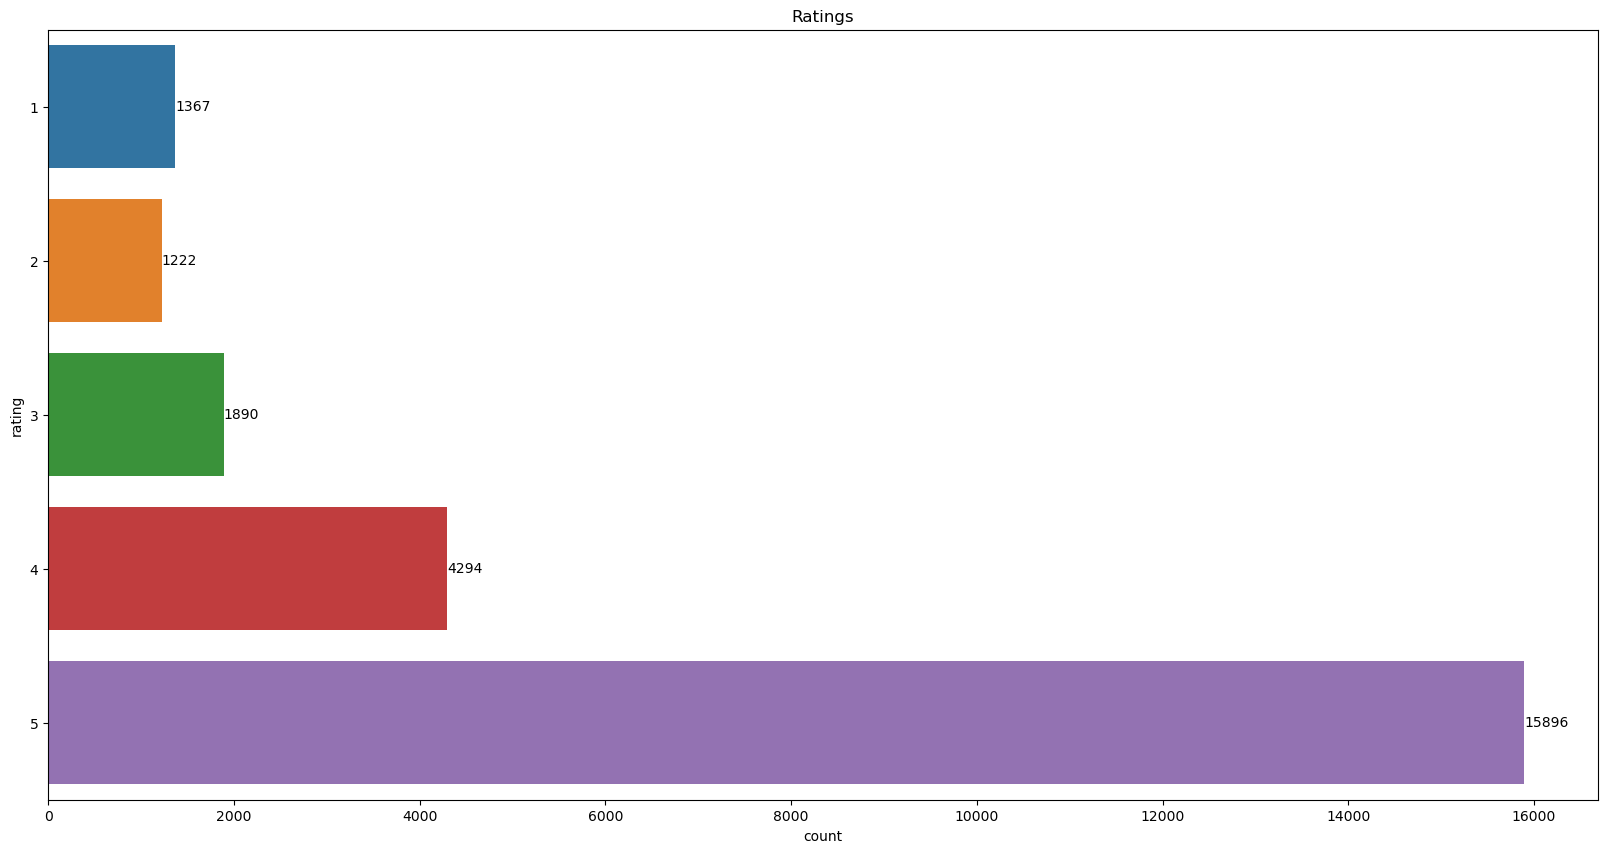

In [128]:
# Ratings
# Size
plt.figure(figsize=(20,10))

# Countplot
ratings_countplot = sns.countplot(y='rating', data=df2)
ratings_countplot.bar_label(ratings_countplot.containers[0]) # Annotations
plt.title('Ratings') # Title

# Show
plt.show()

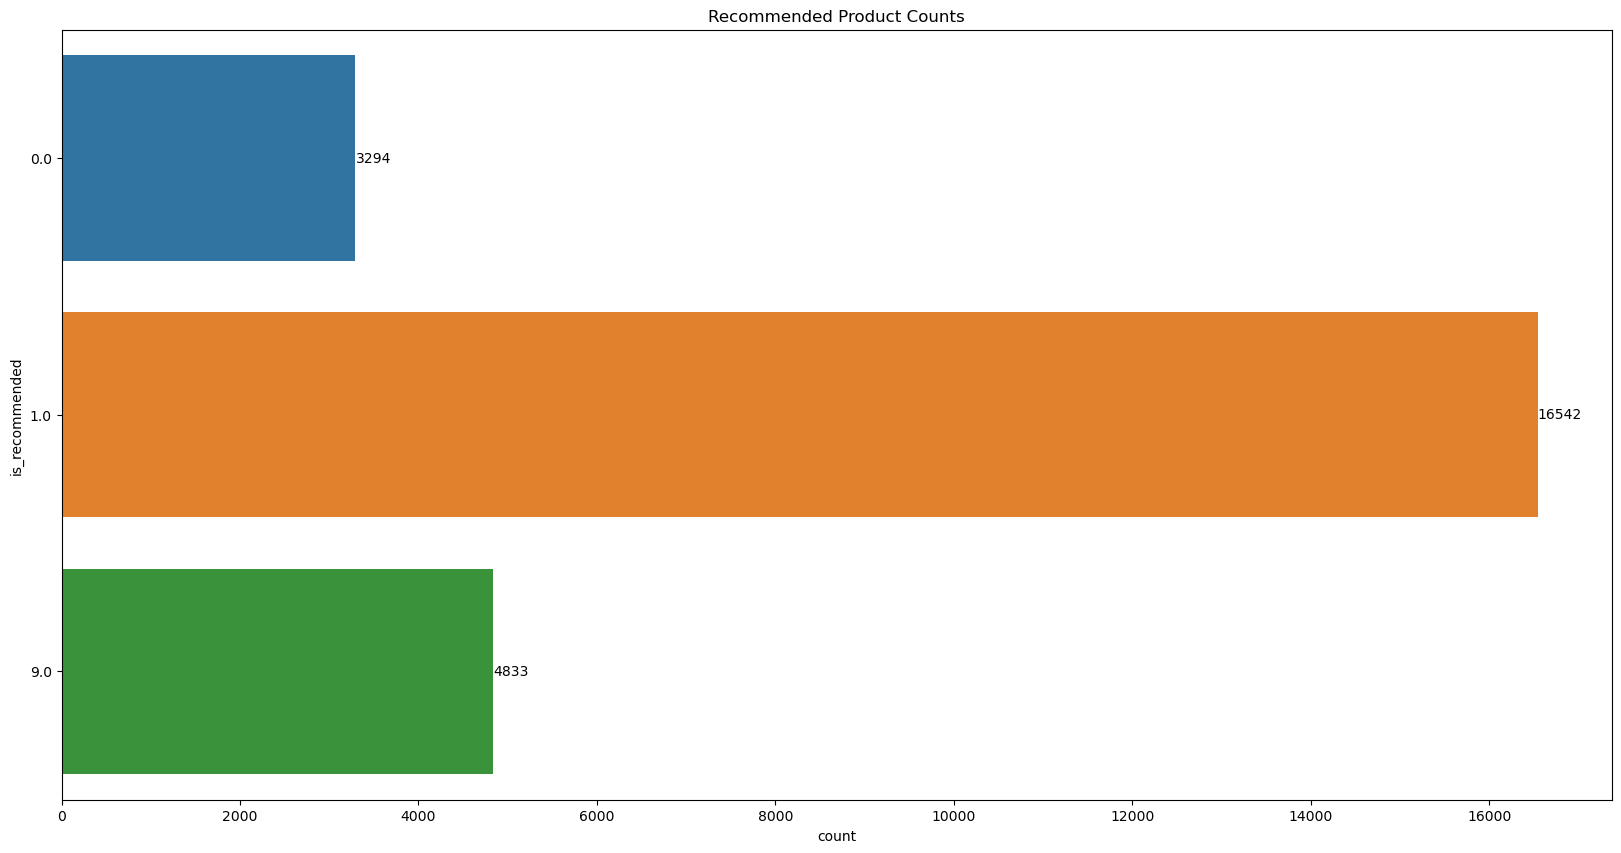

In [129]:
# is_recommended - this will have some null values that will need to be handled.
# The lack of a recommendation either way may also be interesting going forward.
# NaN will be replaced with 9
df2.is_recommended.fillna(9, inplace=True)

# Size
plt.figure(figsize=(20,10))

# Countplot
recommended_countplot = sns.countplot(y='is_recommended', data=df2)
recommended_countplot.bar_label(recommended_countplot.containers[0]) # Annotations
plt.title('Recommended Product Counts') # Title

# Show
plt.show()

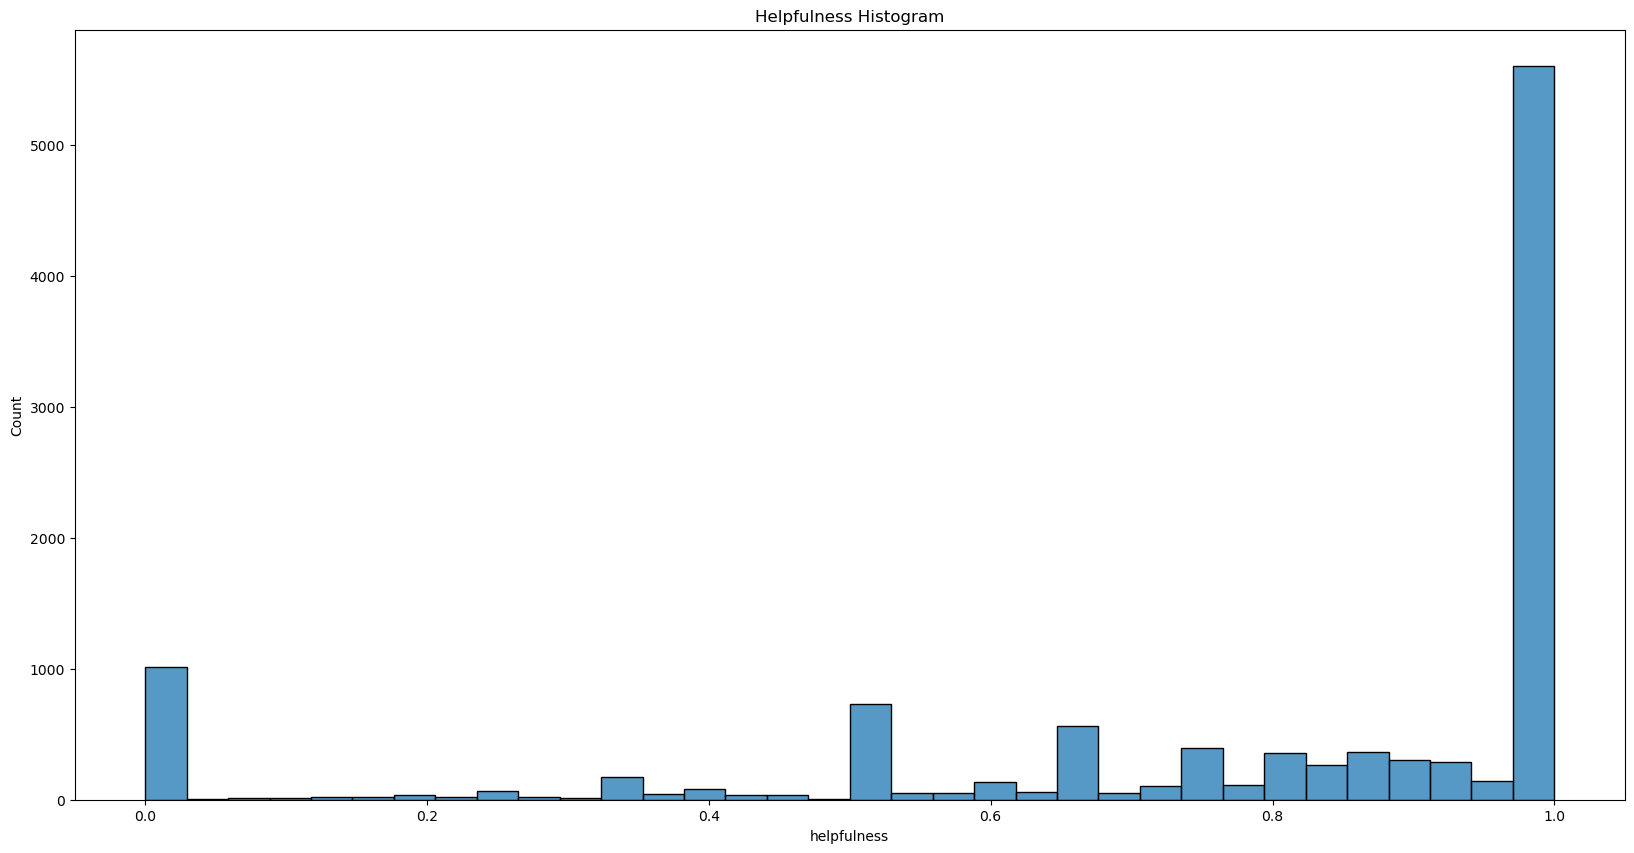

In [130]:
# Helpfulness - also contains a substantial amount of missing values that could impact the variable's use in a model.

# Size
plt.figure(figsize=(20, 10))

# Histogram
helpfulness_hist = sns.histplot(x='helpfulness', data=df2, stat='count')
plt.title('Helpfulness Histogram') # Title

# Show
plt.show()

In [131]:
# Missing values
print(f'There are {df2.helpfulness.isna().sum()} missing values within helpfulness.')

There are 13472 missing values within helpfulness.


A missingness indicator will be calculated for helpfulness because of how many values are missing.

In [165]:
# Collector
helpfulness_missingness = []

# Iterate
for h in range(0, len(df2.helpfulness)):
    if math.isnan(df2.helpfulness[h]):
        helpfulness_missingness.append('missing')
    elif df2.helpfulness[h] < 0.5:
        helpfulness_missingness.append('not helpful')
    elif df2.helpfulness[h] >= 0.5:
        helpfulness_missingness.append('helpful')

# Helpfulness missingness indicator 
df2['helpfulness_missingness'] = helpfulness_missingness

# Check
df2.helpfulness_missingness.describe()

count       24669
unique          3
top       missing
freq        13472
Name: helpfulness_missingness, dtype: object

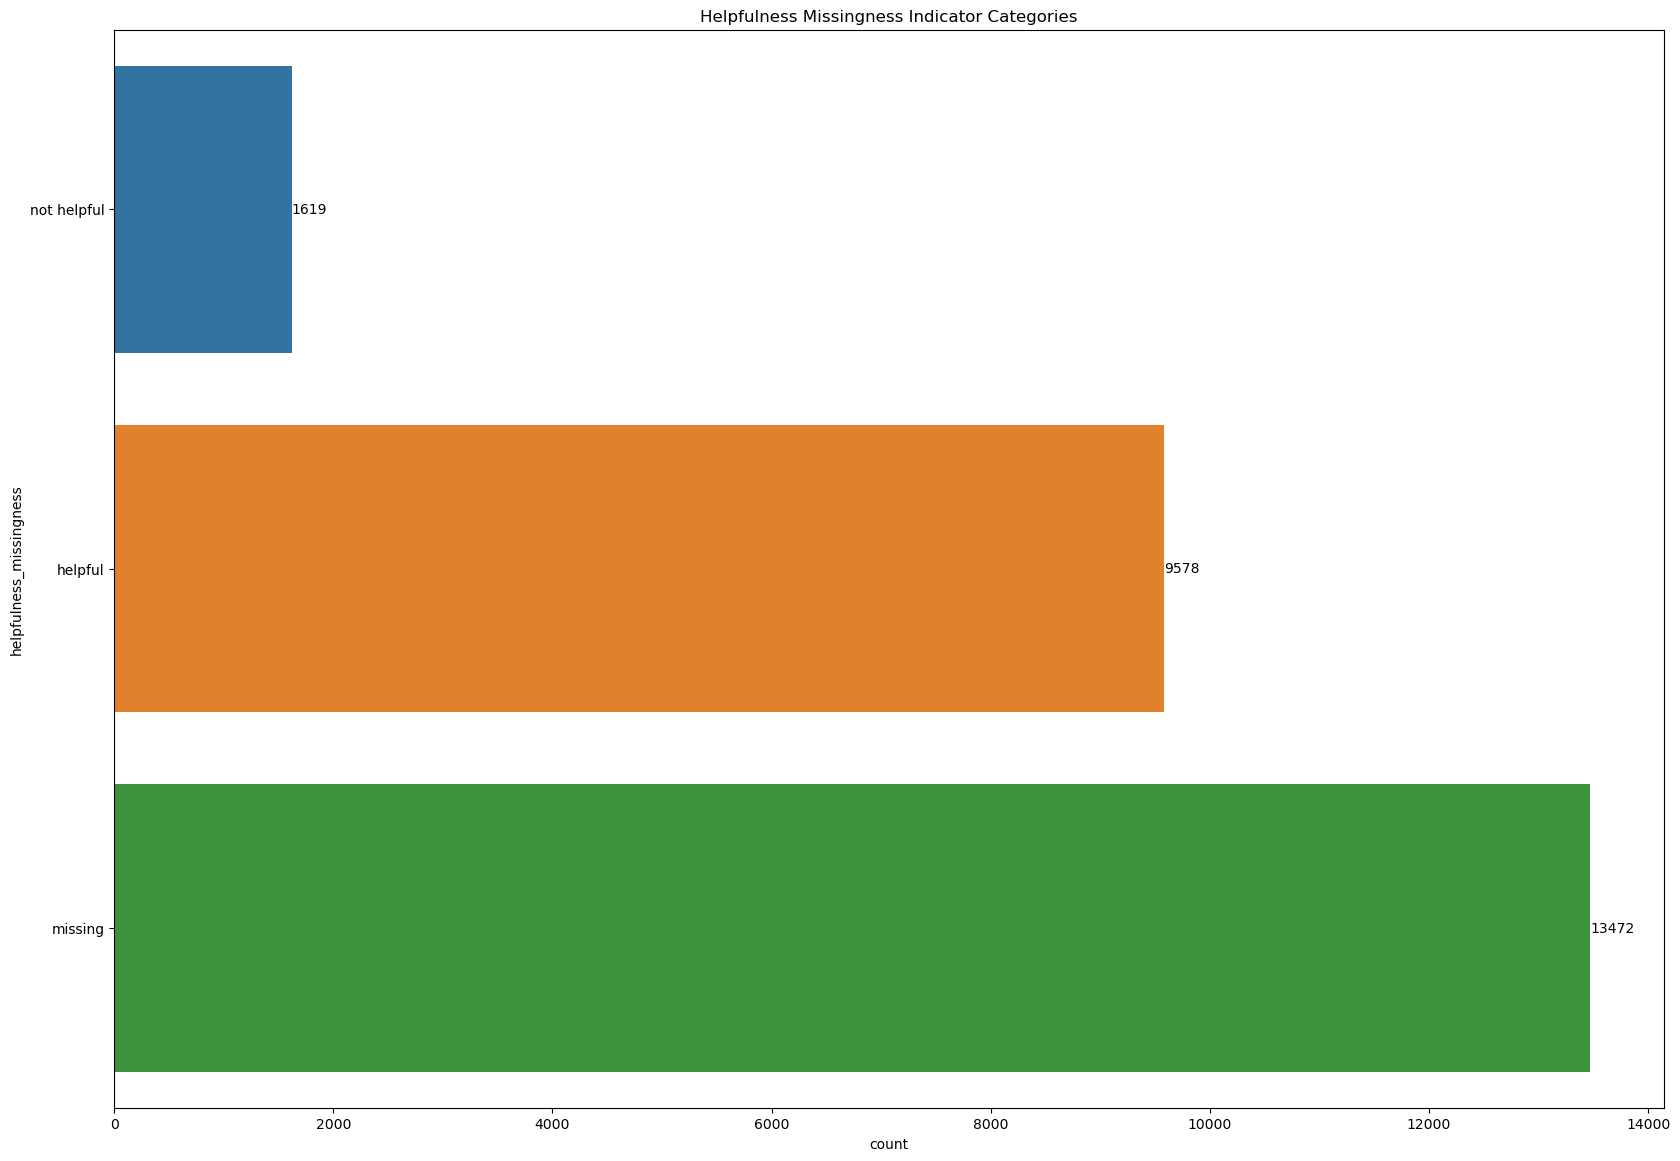

In [167]:
# Visualization
# Size
plt.figure(figsize=(20, 14))

# Countplot - Pie chart made the notebook hang
help_miss_plt = sns.countplot(y='helpfulness_missingness', data=df2)
help_miss_plt.bar_label(help_miss_plt.containers[0]) # Annotations

# Title
plt.title('Helpfulness Missingness Indicator Categories')

# Show
plt.show()

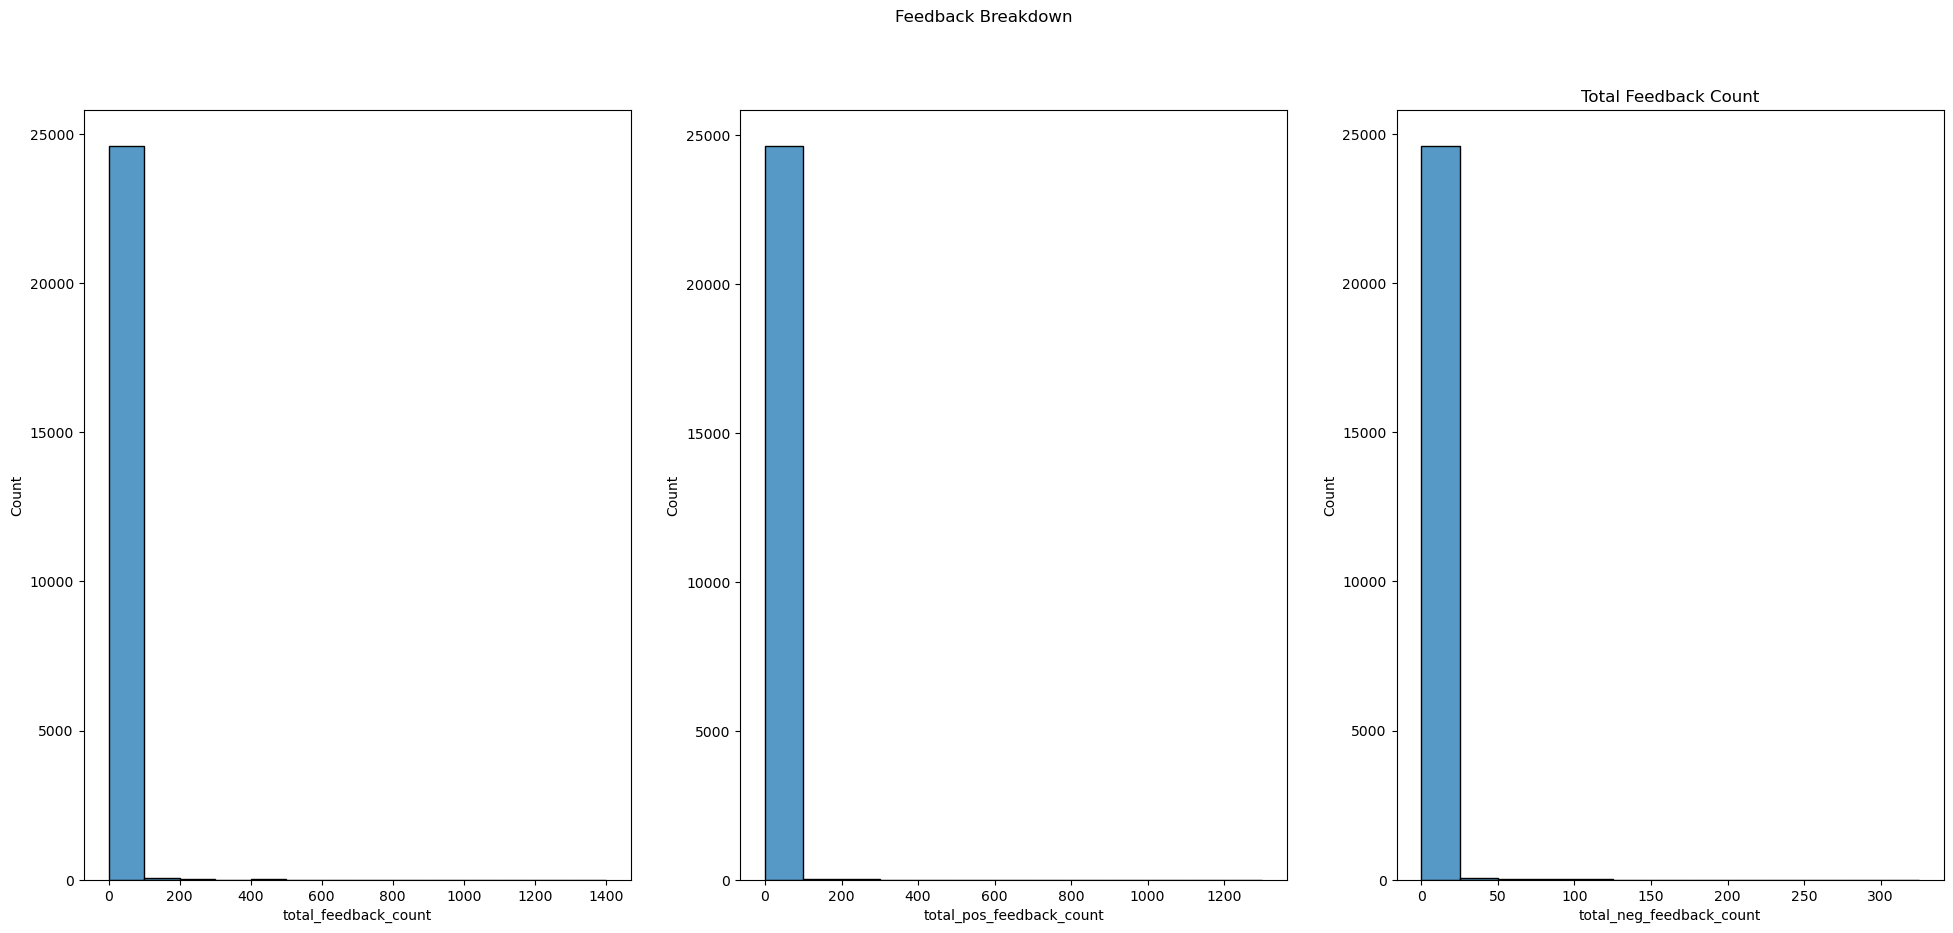

In [135]:
# Total feedback count, total positive feedback, total negative feedback
# Build subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24,10))

# ax0 - total feedback
sns.histplot(x='total_feedback_count', binwidth=100, data=df2, ax=ax0)
plt.title('Total Feedback Count')

# ax1 - total positive feedback
sns.histplot(x='total_pos_feedback_count', binwidth=100, data=df2, ax=ax1)
plt.title('Total Positive Feedback Count')

# ax2 - total negative feedback
sns.histplot(x='total_neg_feedback_count', binwidth=25, data=df2, ax=ax2)
plt.title('Total Feedback Count')

# Titling
plt.suptitle('Feedback Breakdown')

# Show
plt.show()

In [136]:
# Submission Time - Split into year, month
df2['year'] = [i.split('-')[0] for i in df2.submission_time]
df2['month'] = [i.split('-')[1] for i in df2.submission_time]

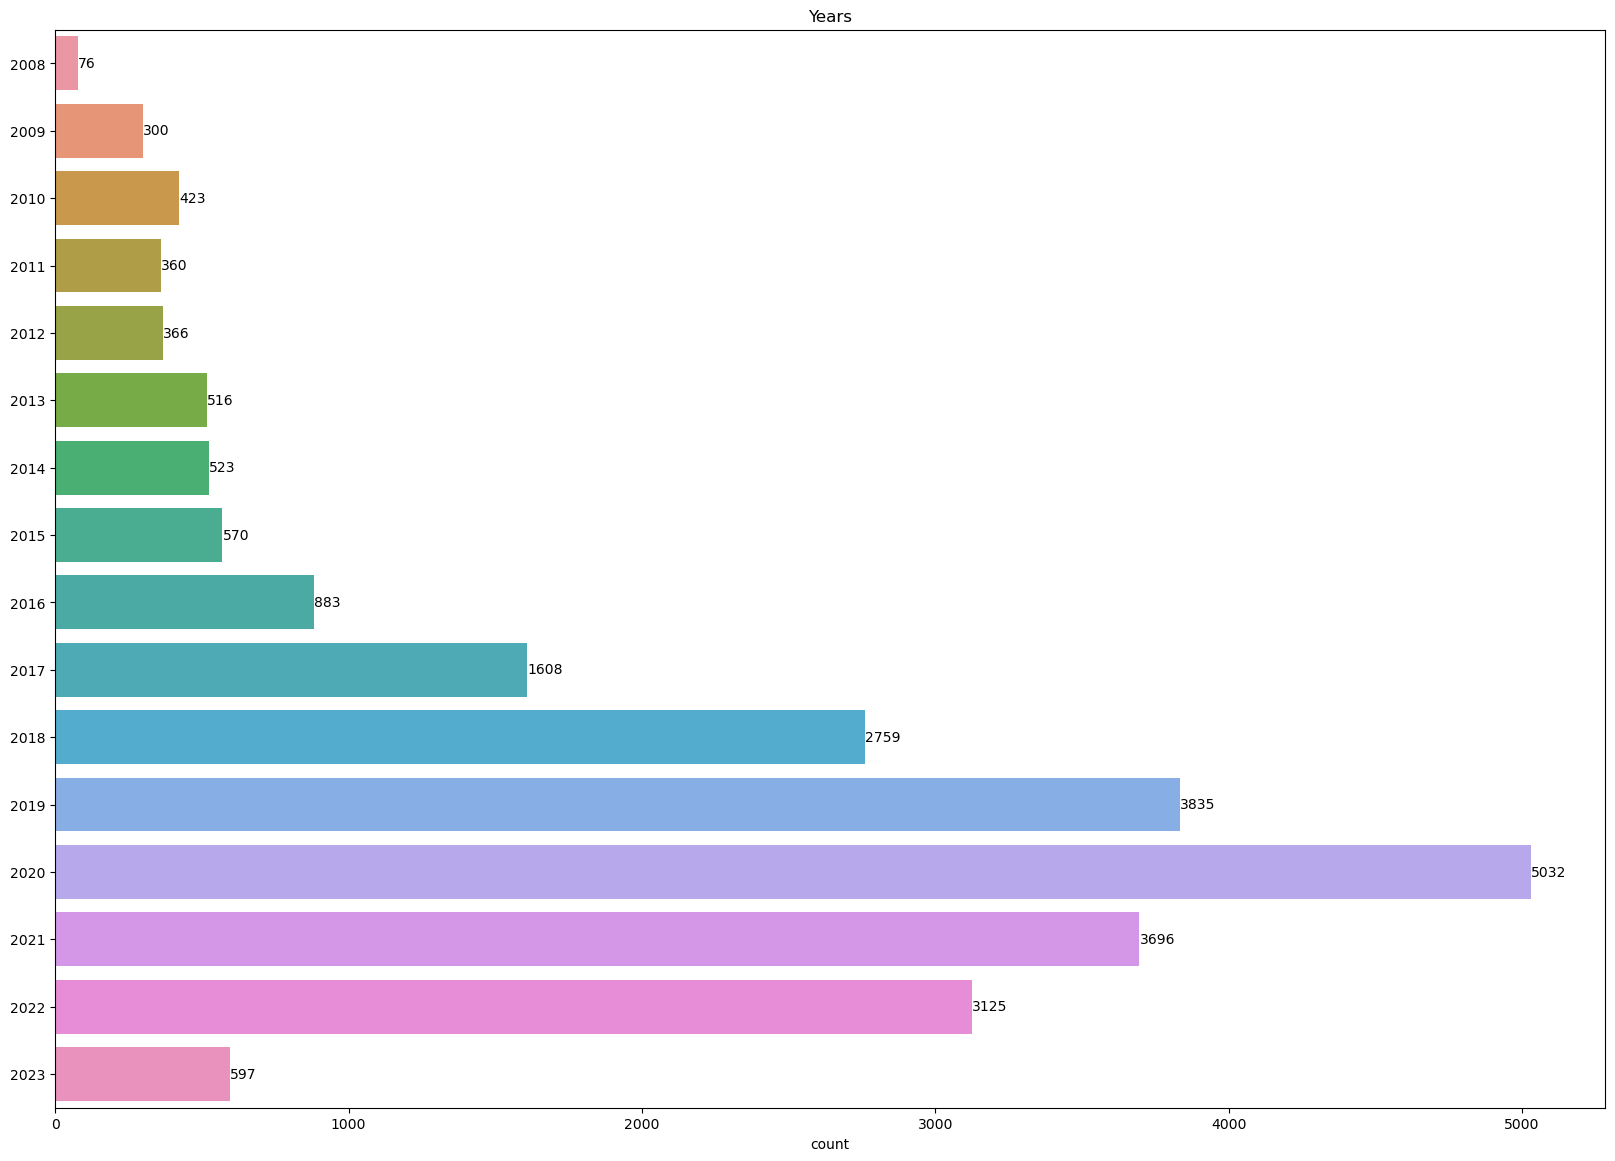

In [137]:
# Breakdown of year
# Size
plt.figure(figsize=(20,14))

# Countplot
year_countplot = sns.countplot(y=sorted(df2['year']), data=df2)
year_countplot.bar_label(year_countplot.containers[0]) # Annotations
plt.title('Years') # Title

# Show
plt.show()

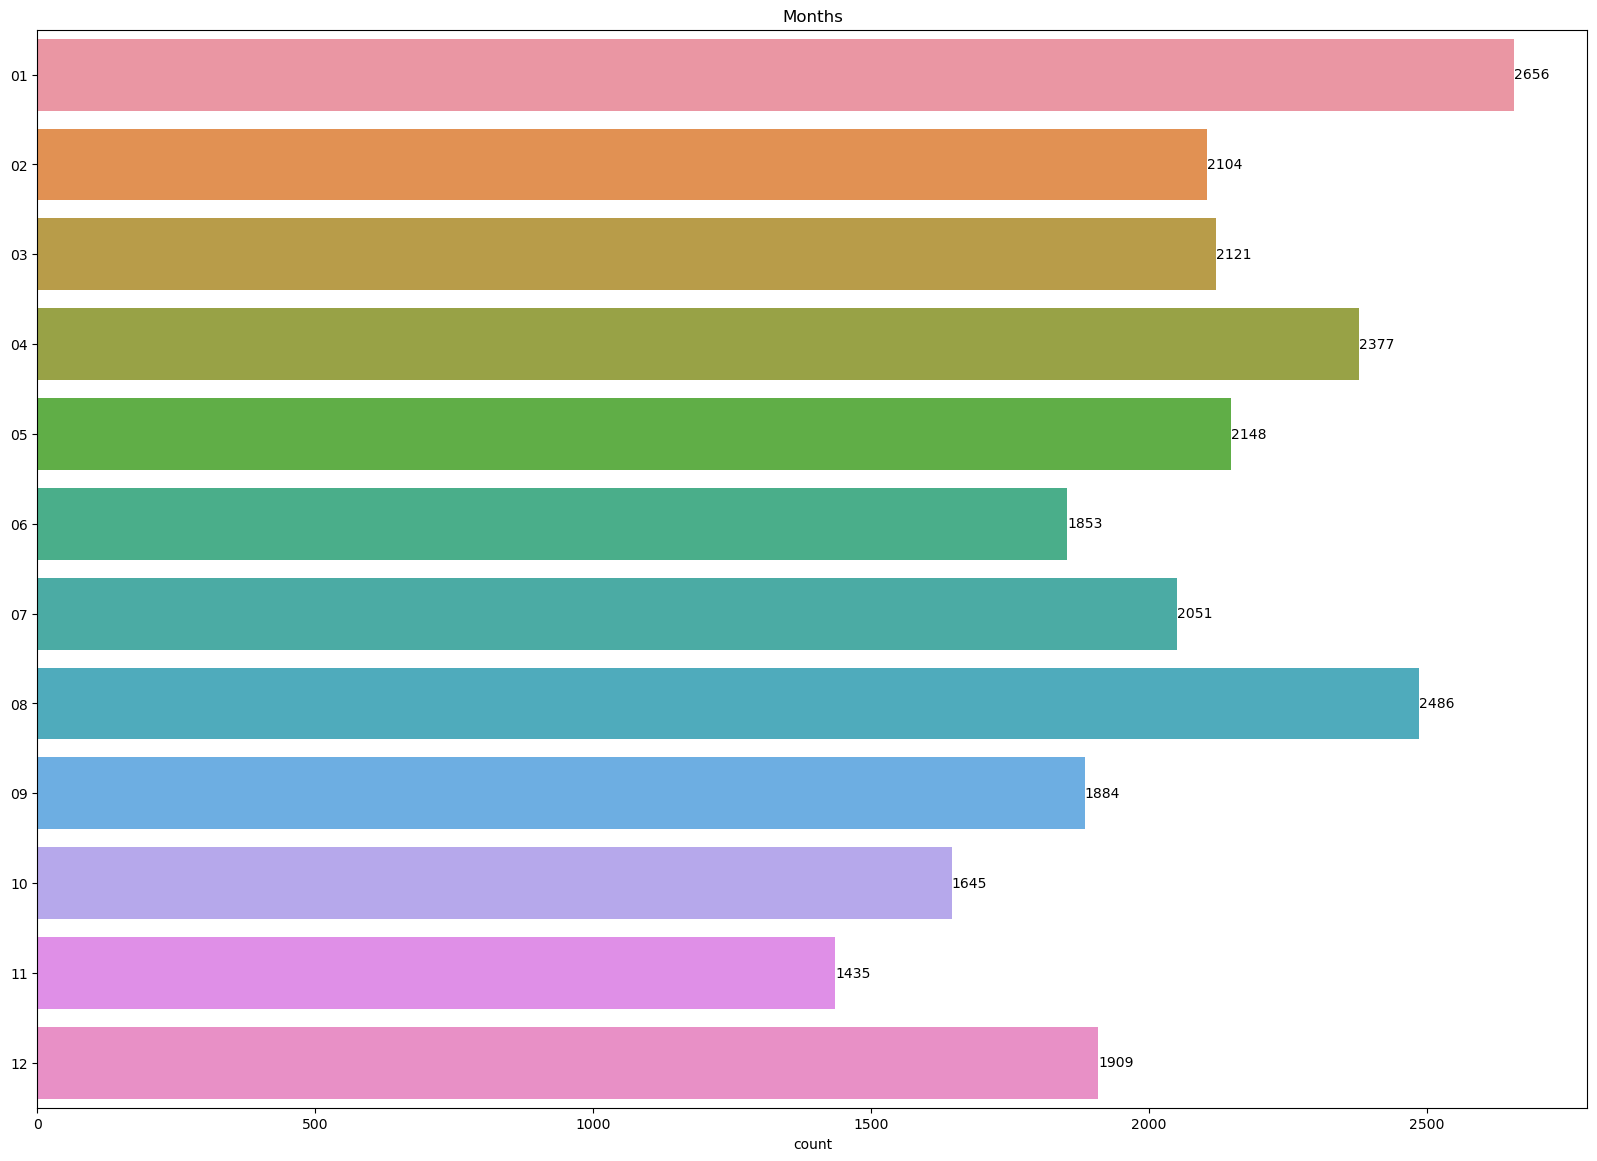

In [138]:
# Break down of month
# Size
plt.figure(figsize=(20,14))

# Countplot
month_countplot = sns.countplot(y=sorted(df2['month']), data=df2)
month_countplot.bar_label(month_countplot.containers[0]) # Annotations
plt.title('Months') # Title

# Show
plt.show()

In [139]:
# Review title - more important to check for the presence of one
print(f'There are {df2.review_title.isna().sum()} reviews missing titles.')

There are 6802 reviews missing titles.


In [140]:
# Skin tone - missing values present
print(f'There are {df2.skin_tone.isna().sum()} missing values for skin tone.')

There are 4340 missing values for skin tone.


In [141]:
# Replace NaN with none
df2.skin_tone.fillna('none', inplace=True)

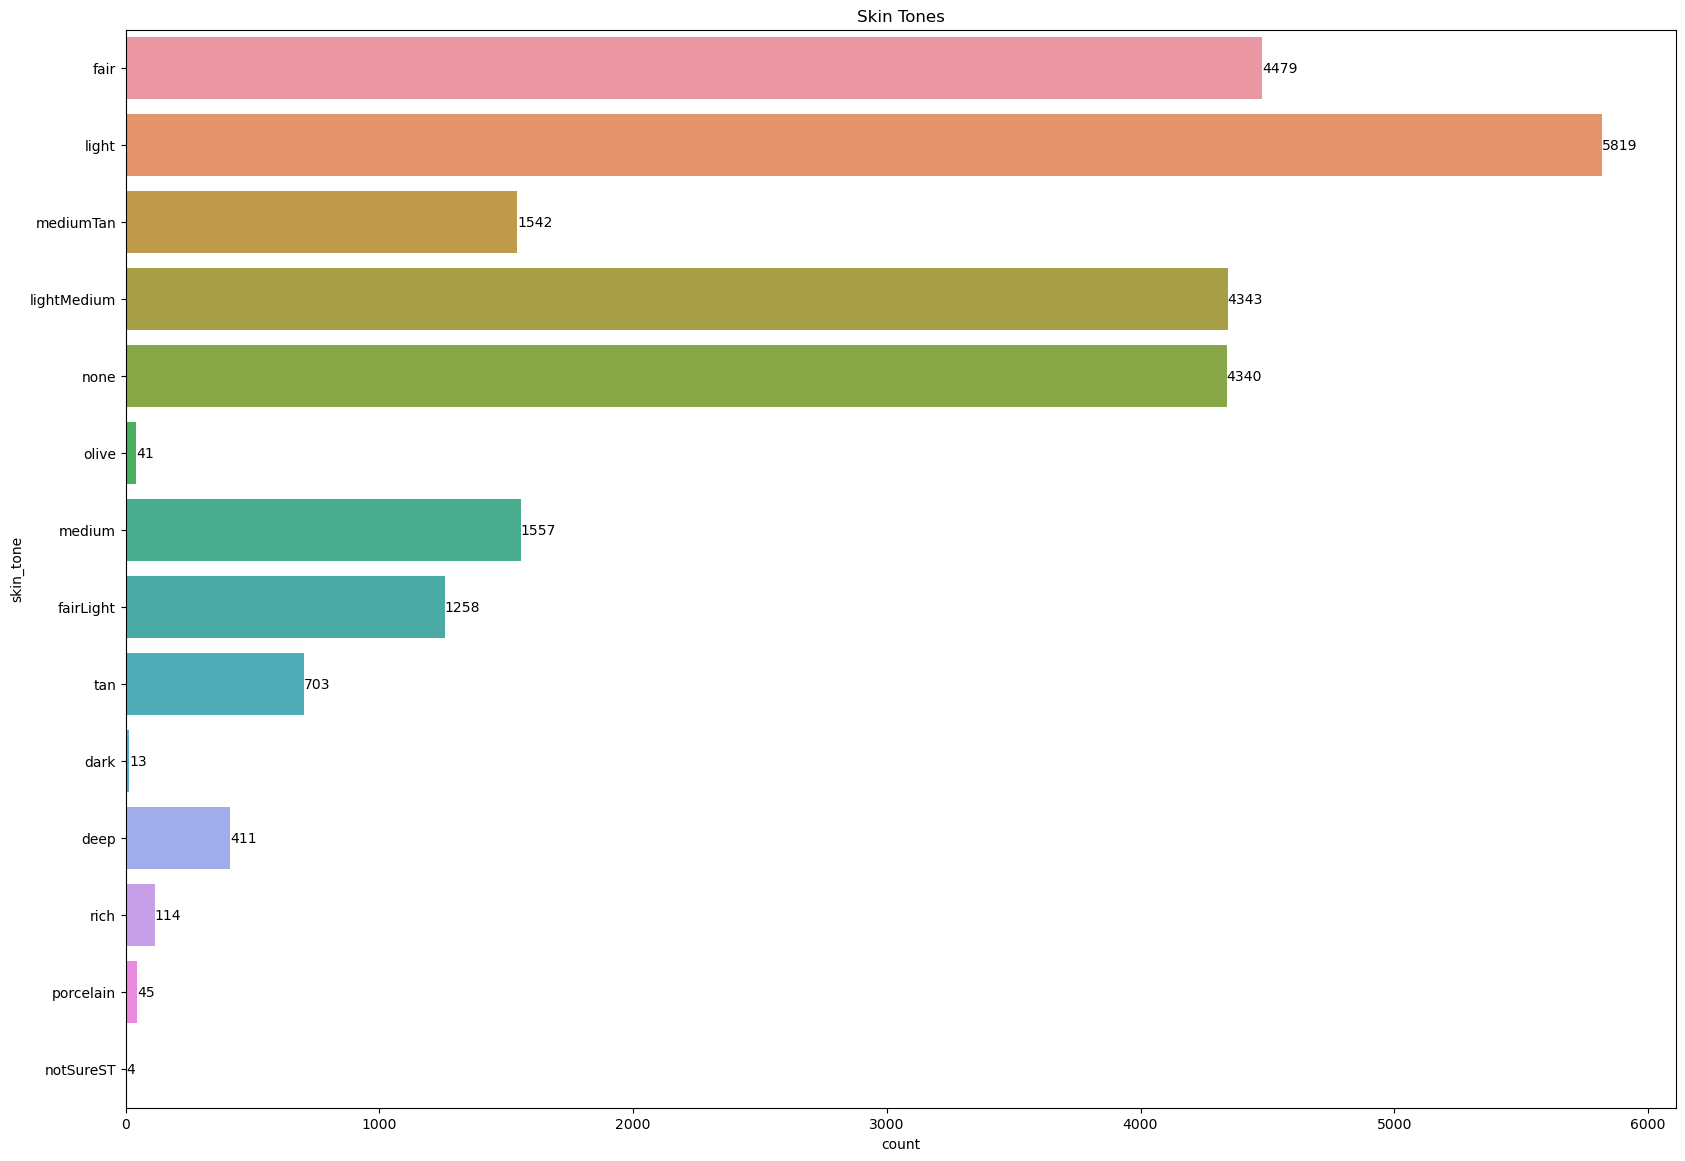

In [142]:
# Visualize skin tone
# Size
plt.figure(figsize=(20,14))

# Countplot
skin_tone_plot = sns.countplot(y='skin_tone', data=df2)
skin_tone_plot.bar_label(skin_tone_plot.containers[0]) # Annotations
plt.title('Skin Tones') # Title

# Show
plt.show()

In [143]:
# Eye color - missing values present
print(f'There are {df2.eye_color.isna().sum()} missing values for eye color.')

There are 5696 missing values for eye color.


In [144]:
# Replace missing values
df2.eye_color.fillna('none', inplace=True)

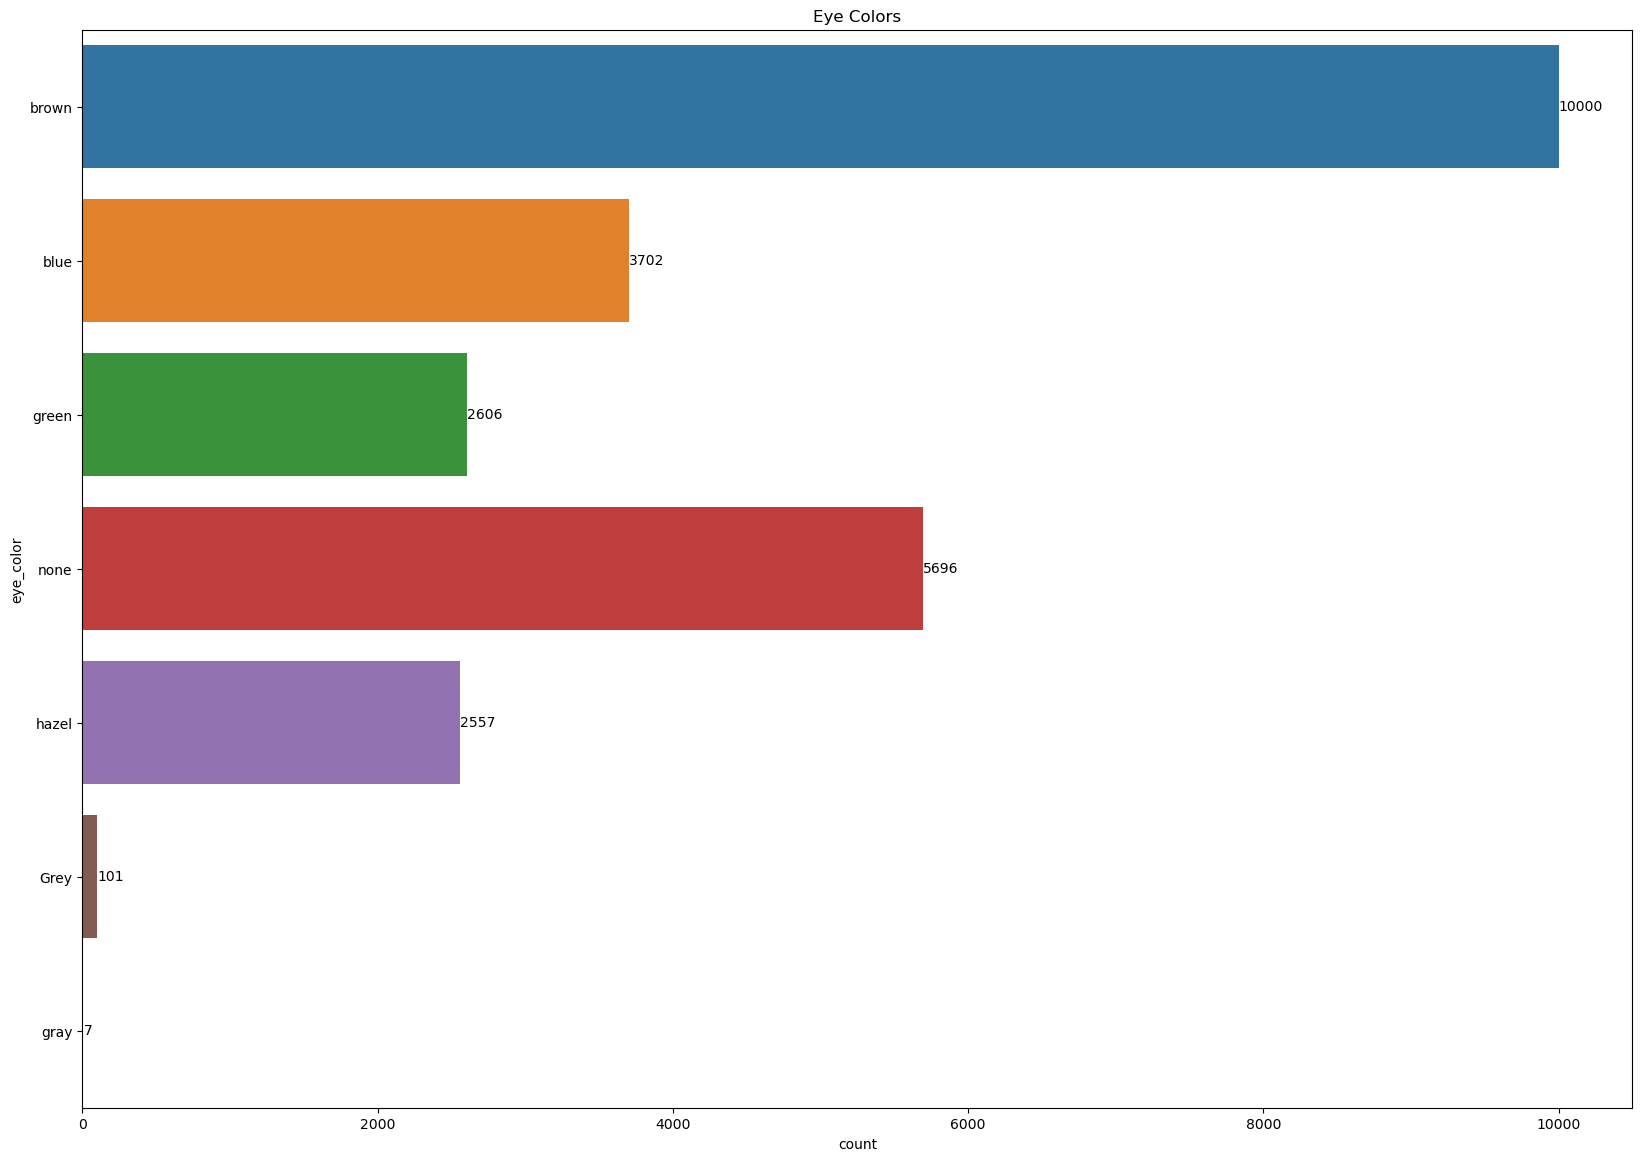

In [145]:
# Visualization
# Size
plt.figure(figsize=(20,14))

# Chart
eye_color_plot = sns.countplot(y='eye_color', data=df2)
eye_color_plot.bar_label(eye_color_plot.containers[0]) # Annotations
plt.title('Eye Colors') # Title

# Show
plt.show()

In [146]:
# Skin type - missing values present
print(f'There are {df2.skin_type.isna().sum()} missing values for skin type.')

There are 3078 missing values for skin type.


In [147]:
# Replace missing values
df2.skin_type.fillna('none', inplace=True)

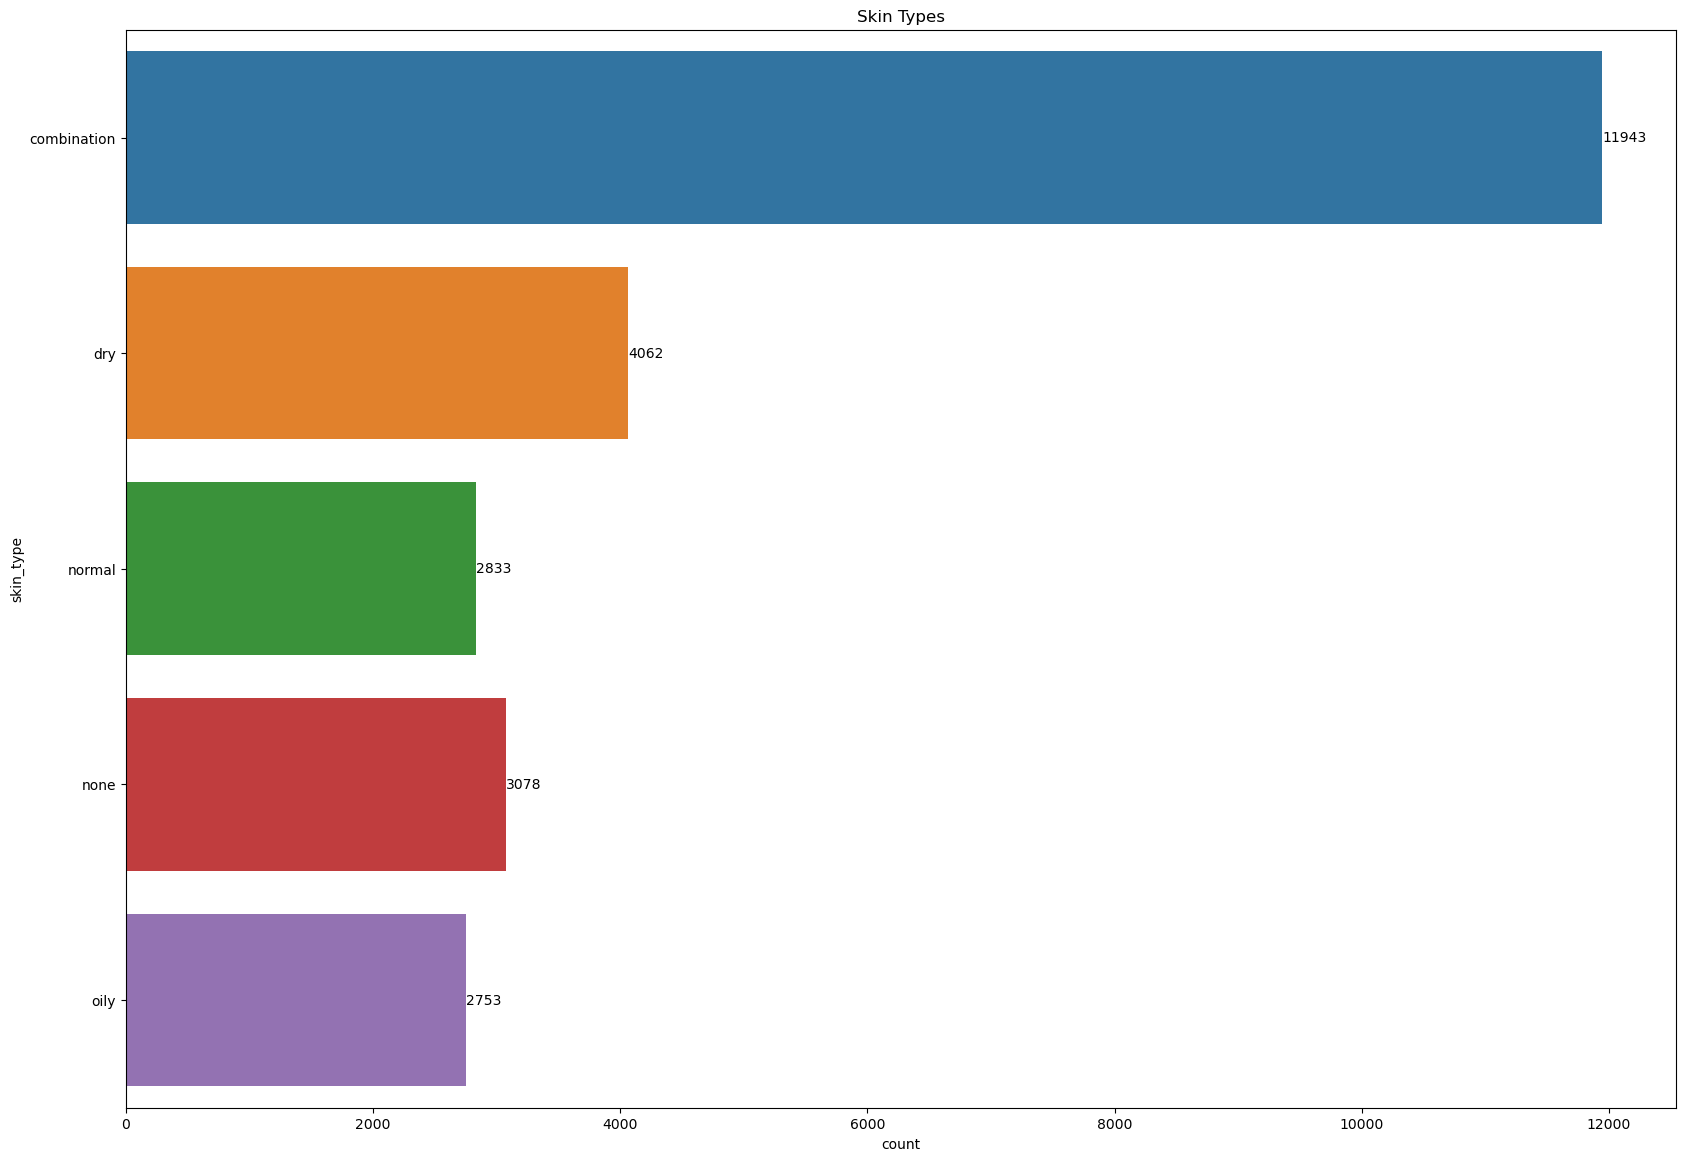

In [148]:
# Visualization
# Size
plt.figure(figsize=(20,14))

# Chart
skin_type_plot = sns.countplot(y='skin_type', data=df2)
skin_type_plot.bar_label(skin_type_plot.containers[0]) # Annotations
plt.title('Skin Types') # Title

# Show
plt.show()

In [149]:
# Hair color - missing values present
print(f'There are {df2.hair_color.isna().sum()} missing values for hair color.')

There are 5793 missing values for hair color.


In [150]:
# Replace missing values
df2.hair_color.fillna('none', inplace=True)

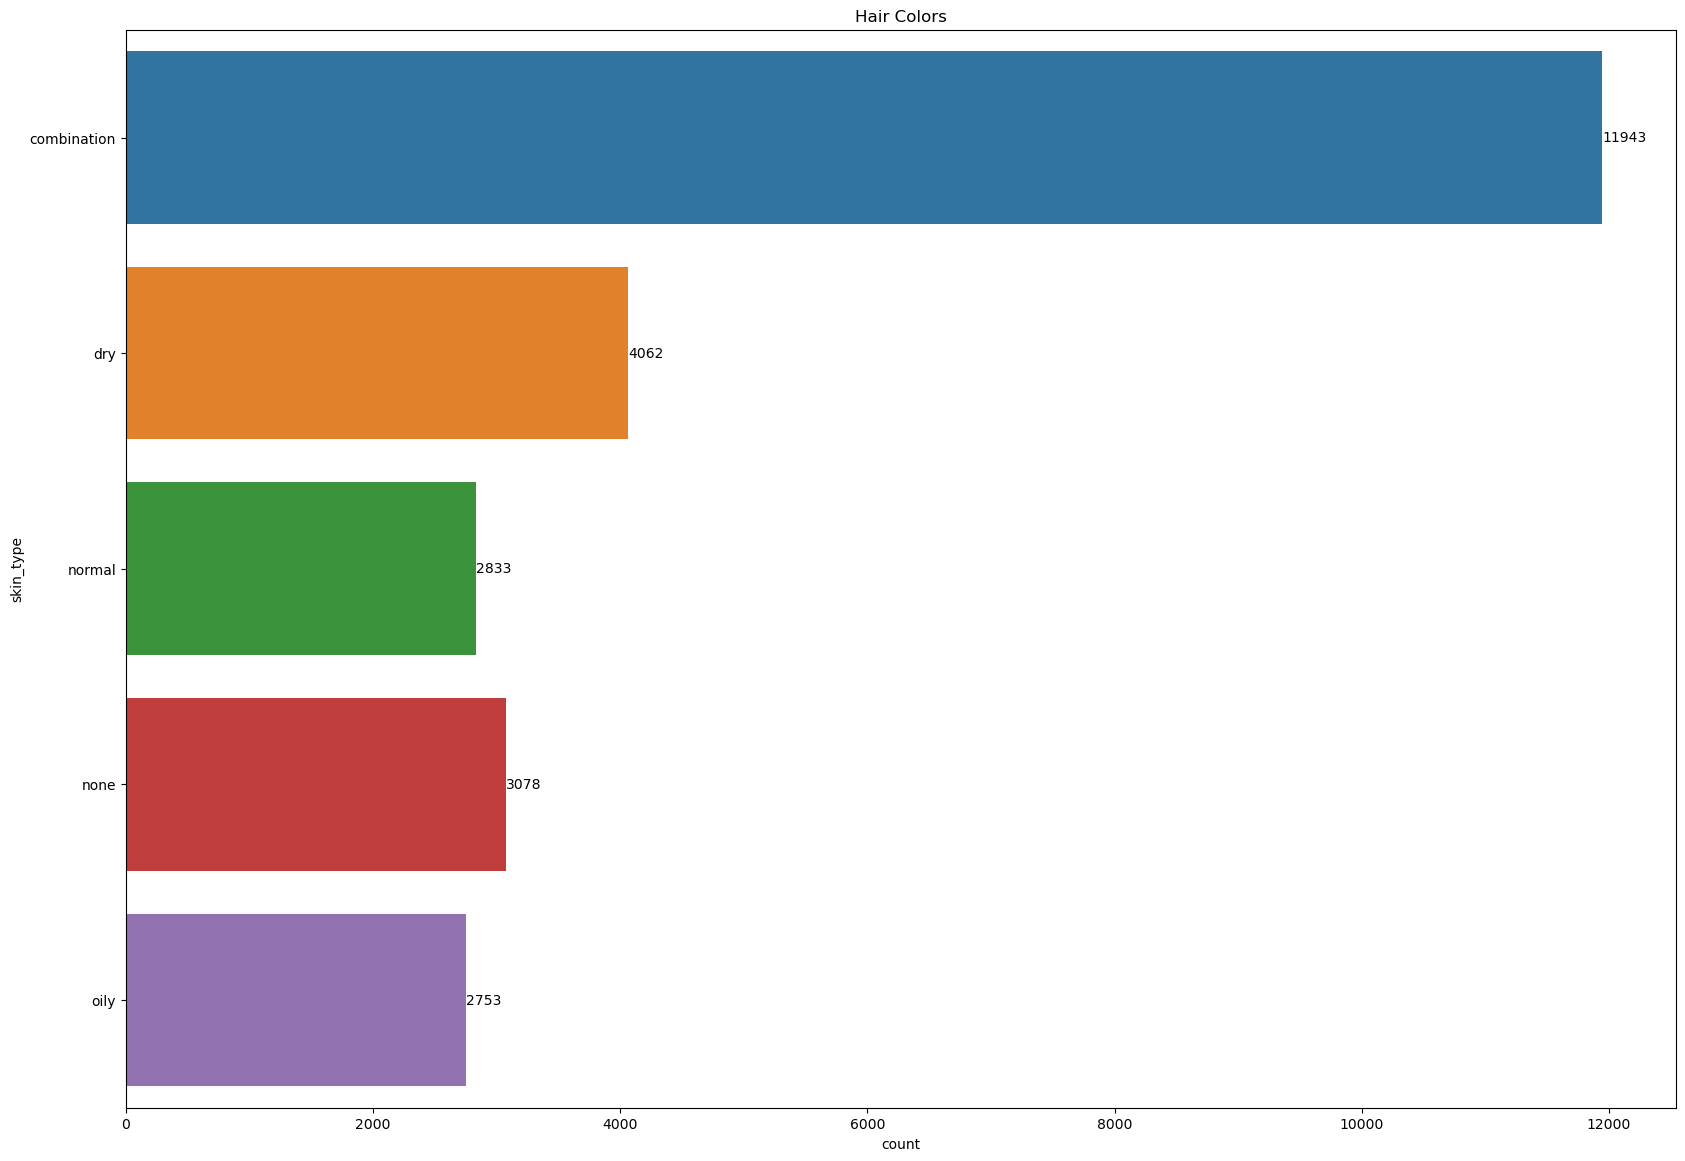

In [151]:
# Visualization
# Size
plt.figure(figsize=(20,14))

# Chart
hair_color_plot = sns.countplot(y='skin_type', data=df2)
hair_color_plot.bar_label(hair_color_plot.containers[0]) # Annotations
plt.title('Hair Colors') # Title

# Show
plt.show()

In [152]:
# Product name
print(f'There are {df2.product_name.nunique()} unique product names.')

There are 245 unique product names.


In [153]:
# Brand name
print(f'There are {df2.brand_name.nunique()} unique brand names.')

There are 59 unique brand names.


In [154]:
# Reset the dataframe's index
df2.reset_index(drop=True, inplace=True)

## Prepare the Data Set
- Split into train, validation, and test sets.
- Apply encoders.
- Scale continuous variables.

In [170]:
# For linear regression with price as the target variable
y_linreg = df2.price_usd

# For logistic regression with rating as the target variable
y_logreg = df2.rating

# Linear Regression predictor variables are everything but price_usd
x_linreg = df2.drop(["price_usd", "review_text", "review_title", "submission_time", "product_name", "brand_name", "helpfulness"], axis=1)

# Logistic Regression predictor variables are everything but ratings
x_logreg = df2.drop(["rating", "review_text", "review_title", "submission_time", "product_name", "brand_name", "helpfulness"], axis=1)

### Focus on Linear Regression Preparation

In [171]:
# Split the data - Linear regression
xlin_train, xlin_test_base, ylin_train, ylin_test_base = train_test_split(x_linreg, y_linreg, test_size = .20, random_state=42)

# Create validation and test - Linear regression
xlin_valid, xlin_test, ylin_valid, ylin_test = train_test_split(xlin_test_base, ylin_test_base, test_size = .50, random_state = 42)

In [172]:
# Check shapes
print(f'Linear regression training set size: {xlin_train.shape[0]} | Validation set size: {xlin_valid.shape[0]} | Test set size: {xlin_test.shape[0]}')

Linear regression training set size: 19735 | Validation set size: 2467 | Test set size: 2467


In [173]:
# Ordinal encoder columns
ordinal_linreg_cols = ['rating', 'is_recommended', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'year', 'month', 'helpfulness_indicator'] # Apply ordinal encoder

# Continuous columns
cont_linreg_cols = ['total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count'] # Apply MaxAbsScaler

In [159]:
# Build transformers
ordinal_linreg_tfrm = ColumnTransformer([])